In [8]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

jungang_col = keti_db.jungang_pattern
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [10]:
# DB Config
uid = "아파트1-103-1104"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time

timestamp = date_time.map(dt.timestamp)

day = 24*60*60
week = 7*day
year = (365.2425)*day

hh_datas['week sin'] = np.sin(timestamp * (2 * np.pi / week)).values
hh_datas['week cos'] = np.cos(timestamp * (2 * np.pi / week)).values
hh_datas['year sin'] = np.sin(timestamp * (2 * np.pi / year)).values
hh_datas['year cos'] = np.cos(timestamp * (2 * np.pi / year)).values

hh_datas

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.153,-0.846724,-0.532032,0.880785,-0.473516
2018-05-01 00:15:00,0.146,-0.851662,-0.524092,0.880700,-0.473674
2018-05-01 00:30:00,0.128,-0.856525,-0.516106,0.880615,-0.473832
2018-05-01 00:45:00,0.118,-0.861313,-0.508075,0.880530,-0.473990
2018-05-01 01:00:00,0.119,-0.866025,-0.500000,0.880445,-0.474148
...,...,...,...,...,...
2019-04-30 22:45:00,0.177,-0.958287,0.285808,0.883173,-0.469047
2019-04-30 23:00:00,0.173,-0.955573,0.294755,0.883089,-0.469205
2019-04-30 23:15:00,0.160,-0.952775,0.303677,0.883005,-0.469363


In [11]:
jungang_db_cur = jungang_col.find()
db_datas = [_ for _ in jungang_db_cur]

jg_datas = pd.DataFrame(columns=['Date Time','energy (kw 15min)'])
jg_datas['Date Time'] = [_['ttime'] for _ in db_datas]
jg_datas['energy (kw 15min)'] = [_['energy'] for _ in db_datas]

date_time = pd.to_datetime(jg_datas.pop('Date Time'),
                          format="%Y-%m-%d %H:%M:%S")
jg_datas.index = date_time
jg_datas

,energy (kw 15min)
Date Time,
2017-01-01 00:00:00,15250
2017-01-01 00:15:00,15250
2017-01-01 00:30:00,13750
2017-01-01 00:45:00,14250
2017-01-01 01:00:00,14000
...,...
2020-04-08 22:45:00,0
2020-04-08 23:00:00,0
2020-04-08 23:15:00,0


In [12]:
idx = jg_datas.index.get_loc(jg_datas[jg_datas['energy (kw 15min)'] == 0].index[7])

jg_datas = jg_datas.iloc[:idx].copy()

In [13]:
def calc_sin(ts, target_value):
    return np.sin(ts * (2 * np.pi / target_value)).values
def calc_cos(ts, target_value):
    return np.cos(ts * (2 * np.pi / target_value)).values
def get_season(month):
    if month in [3,4,5]:
        return "봄"
    elif month in [6,7,8]:
        return "여름"
    elif month in [9,10,11]:
        return "가을"
    else:
        return "겨울"

# ~ 2018 year data parsing
jg_datas = jg_datas[jg_datas.index.year <= 2018]
date_time = jg_datas.index
timestamp = date_time.map(dt.timestamp)

day = 24 * 60 * 60
week = 7 * day
year = (365) * day

jg_datas['week sin'] = calc_sin(timestamp, week)
jg_datas['week cos'] = calc_cos(timestamp, week)
jg_datas['year sin'] = calc_sin(timestamp, year)
jg_datas['year cos'] = calc_cos(timestamp, year)
jg_datas['season'] = [get_season(_.month) for _ in jg_datas.index]

jg_datas = jg_datas[::4]
jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season
Date Time,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울
...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을


In [15]:
day_1_size = 24
year_half_size = day_1_size * int(365 / 4) 
year_1_size = day_1_size * 365

training_datas = jg_datas[:year_1_size]
validation_datas = jg_datas[year_1_size:
                        year_1_size + year_half_size]
testing_datas = jg_datas[year_1_size + year_half_size:]

In [16]:
all_dict = dict()
train_type = ['univariate', 'multivariate', 'season univariate', 'season multivariate']
uni_columns = ['energy (kw 15min)']
mul_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'year sin', 'year cos']
seasons = ["봄", "여름", "가을", "겨울"]

for t_type in train_type:
    if 'season' in t_type:
        seasons_dict = dict()
        for season in seasons:
            season_dict = dict()
            in_col = mul_columns if "multivariate" in t_type else uni_columns
            
            season_dict['train'] = training_datas[in_col][training_datas['season'] == season].copy()
            season_dict['val'] = validation_datas[in_col].copy()
            season_dict['test'] = testing_datas[in_col].copy()
            
            seasons_dict[season] = season_dict
        all_dict[t_type] = seasons_dict
    else:
        in_dict = dict()
        in_col = mul_columns if "multivariate" in t_type else uni_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict

In [17]:
norm_all_dict = dict()

mean = training_datas[mul_columns].mean()
std = training_datas[mul_columns].std()

for key in all_dict.keys():
    in_col = mul_columns if "multivariate" in key else uni_columns
    in_dict = all_dict[key].copy()
    m = mean[in_col]
    s = std[in_col]
    
    if "season" in key:
        for season in seasons:
            train = in_dict[season]['train'].copy()
            val = in_dict[season]['val'].copy()
            test = in_dict[season]['test'].copy()
            
            in_dict[season]['train'] = (train - m) / s
            in_dict[season]['val'] = (val - m) / s
            in_dict[season]['test'] = (test - m) / s
    else:
        train = in_dict['train'].copy()
        val = in_dict['val'].copy()
        test = in_dict['test'].copy()
        
        in_dict['train'] = (train - m) / s
        in_dict['val'] = (val - m) / s
        in_dict['test'] = (test - m) / s
        
    norm_all_dict[key] = in_dict

In [18]:
windows = dict()

for key in norm_all_dict.keys():
    nad = norm_all_dict[key]
    
    if "season" in key:
        seasons_window = dict()
        for season in seasons:
            season_window = dict()
            for WINDOW_WIDTH in range(3, 21):
                h_key = "{} hours".format(WINDOW_WIDTH)
                season_window[h_key] = WindowGenerator(
                        input_width=WINDOW_WIDTH,
                        label_width=1,
                        shift=1,
                        label_columns=uni_columns,
                        train_df=nad[season]['train'],
                        val_df=nad[season]['val'],
                        test_df=nad[season]['test']
                    )
            seasons_window[season] = season_window
        windows[key] = seasons_window
    else:
        window = dict()
        for WINDOW_WIDTH in range(3, 21):
            h_key = "{} hours".format(WINDOW_WIDTH)
            window[h_key] = WindowGenerator(
                        input_width=WINDOW_WIDTH,
                        label_width=1,
                        shift=1,
                        label_columns=uni_columns,
                        train_df=nad['train'],
                        val_df=nad['val'],
                        test_df=nad['test']
                    )
        windows[key] = window

In [29]:
cur_cluster_result = cluster_col.find({
    "uid": "jungang_pattern"
})
cluster_result = dict()

for data in cur_cluster_result:
    in_dict = pd.DataFrame(columns=['Label', 'Weekday'])
    in_dict.index.name = "Date Time"
    
    season = data['season']
    infos = data['info']
    
    dtime = [dt.strptime(_['date'], "%Y-%m-%d") for _ in infos]
    labels = [_['label'] for _ in infos]

    for idx, _ in enumerate(dtime):
        label = labels[idx]        
        in_dict.loc[_] = [label, _.weekday()]
        
    cluster_result[season] = in_dict
    
cluster_pattern_dict = dict()

for season in seasons:
    result = cluster_result[season]
    in_dict = pd.DataFrame(columns=[_ for _ in range(0, 24)])
    in_dict.index.name = "Label"
    
    labels = list(set(result['Label']))
    for label in labels:
        cluster_pattern = np.array([])
        date_in_labels = result[result['Label'] == label].index
        for date in date_in_labels:
            idx = jg_datas.index.get_loc(date)
            pattern = jg_datas.iloc[idx: idx+24]['energy (kw 15min)'].values
            cluster_pattern = np.append(cluster_pattern, pattern)
        cluster_pattern = cluster_pattern.reshape(-1,24).mean(axis=0)
        in_dict.loc[label] = cluster_pattern
        
    cluster_pattern_dict[season] = in_dict

cluster_norm_dict = dict()

mean = all_dict['univariate']['train'].mean().values[0]
std = all_dict['univariate']['train'].std().values[0]

for key in cluster_pattern_dict.keys():
    cluster_norm_dict[key] = ((cluster_pattern_dict[key] - mean) / std).copy()

In [31]:
cluster_dist_dict = dict()
for season in cluster_result.keys():
    cluster_season_dict = dict()
    week_list = set(cluster_result[season]['Weekday'])
    for week in week_list:
        week_dist = cluster_result[season][
            cluster_result[season]['Weekday'] == week
        ]['Weekday'].groupby(cluster_result[season]['Label']).count().sort_values(ascending=False)
        week_top_label = week_dist.index[0]
        
        cluster_season_dict[week] = week_top_label
    cluster_dist_dict[season] = cluster_season_dict

In [274]:
# Cluster Df is Only Train Df
class ClusterWindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, cluster_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.cluster_df = cluster_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}',
        f'Column indices: {self.column_indices}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
    
  return inputs, labels

def cluster_split_window(self, features):
  inputs = features[:, self.input_slice, :]
  inputs.set_shape([None, self.input_width, None])
    
  return inputs, labels

def cluster_split_window_2(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
    
  return labels

ClusterWindowGenerator.split_window = split_window
ClusterWindowGenerator.cluster_split_window = cluster_split_window
ClusterWindowGenerator.cluster_split_window_2 = cluster_split_window_2

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

ClusterWindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

def make_cluster_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.cluster_split_window)

  return ds

def make_cluster_dataset_2(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.cluster_split_window_2)

  return ds

ClusterWindowGenerator.make_dataset = make_dataset
ClusterWindowGenerator.make_cluster_dataset = make_cluster_dataset
ClusterWindowGenerator.make_cluster_dataset_2 = make_cluster_dataset_2

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def train_with_cluster(self):
  return self.make_cluster_dataset(self.train_df)

@property
def train_with_cluster_label(self):
  return self.make_cluster_dataset_2(self.cluster_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def cluster(self):
  return self.make_dataset(self.cluster_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

ClusterWindowGenerator.train = train
ClusterWindowGenerator.train_with_cluster = train_with_cluster
ClusterWindowGenerator.train_with_cluster_label = train_with_cluster_label
ClusterWindowGenerator.cluster = cluster
ClusterWindowGenerator.val = val
ClusterWindowGenerator.test = test
ClusterWindowGenerator.example = example

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history



In [285]:
def compile_and_fit_cluster(model, window, patterns,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train_with_cluster, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [304]:
nad = norm_all_dict['univariate']

cluster_time_series = pd.DataFrame(columns=['energy (kw 15min)'])
train_df = nad['train'].copy()
for idx in range(0,len(train_df), 24):
    in_pd = pd.DataFrame(columns=['energy (kw 15min)'])
    index = train_df.iloc[idx: idx+24].index
    
    season = get_season(index[0].month)
    weekday = index[0].weekday()
    label = cluster_dist_dict[season][weekday]
    c_pattern = cluster_norm_dict[season].iloc[label].values
    
    for idx, _ in enumerate(index):
        in_pd.loc[_] = c_pattern[idx]
        
    cluster_time_series = pd.concat([cluster_time_series, in_pd])
    
nad['train']['cluster energy'] = cluster_time_series['energy (kw 15min)']
nad['train']

cluster_time_series = pd.DataFrame(columns=['energy (kw 15min)'])
val_df = nad['val'].copy()
for idx in range(0,len(val_df), 24):
    in_pd = pd.DataFrame(columns=['energy (kw 15min)'])
    index = val_df.iloc[idx: idx+24].index
    
    season = get_season(index[0].month)
    weekday = index[0].weekday()
    label = cluster_dist_dict[season][weekday]
    c_pattern = cluster_norm_dict[season].iloc[label].values
    
    for idx, _ in enumerate(index):
        in_pd.loc[_] = c_pattern[idx]
        
    cluster_time_series = pd.concat([cluster_time_series, in_pd])
    
nad['val']['cluster energy'] = cluster_time_series['energy (kw 15min)']
nad['val']


cw = WindowGenerator(
    input_width=3,
    label_width=1,
    shift=1,
    label_columns=uni_columns,
    train_df=nad['train'],
    val_df=nad['val'],
    test_df=nad['test'],
)

In [305]:
lstm_model = tf.keras.models.Sequential([
                # Shape [batch, time, features] => [batch, time, lstm_units]
                tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
                # Shape => [batch, time, features]
                tf.keras.layers.Dense(units=1)
            ])

compile_and_fit(lstm_model, cw)

Epoch 1/100
274/274 [==============================] - 2s 4ms/step - loss: 0.3550 - mean_absolute_error: 0.4562 - val_loss: 0.2950 - val_mean_absolute_error: 0.4077
Epoch 2/100
274/274 [==============================] - 1s 3ms/step - loss: 0.2248 - mean_absolute_error: 0.3500 - val_loss: 0.2571 - val_mean_absolute_error: 0.3624
Epoch 3/100
274/274 [==============================] - 1s 3ms/step - loss: 0.2145 - mean_absolute_error: 0.3379 - val_loss: 0.2413 - val_mean_absolute_error: 0.3423
Epoch 4/100
274/274 [==============================] - 1s 3ms/step - loss: 0.2116 - mean_absolute_error: 0.3342 - val_loss: 0.2331 - val_mean_absolute_error: 0.3305
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 0.2093 - mean_absolute_error: 0.3317 - val_loss: 0.2277 - val_mean_absolute_error: 0.3219
Epoch 6/100
274/274 [==============================] - 1s 3ms/step - loss: 0.2071 - mean_absolute_error: 0.3296 - val_loss: 0.2234 - val_mean_absolute_error: 0.3154
Epoch 7/10

274/274 [==============================] - 1s 3ms/step - loss: 0.1811 - mean_absolute_error: 0.3033 - val_loss: 0.1972 - val_mean_absolute_error: 0.2933
Epoch 51/100
274/274 [==============================] - 1s 3ms/step - loss: 0.1809 - mean_absolute_error: 0.3031 - val_loss: 0.1970 - val_mean_absolute_error: 0.2930
Epoch 52/100
274/274 [==============================] - 1s 3ms/step - loss: 0.1808 - mean_absolute_error: 0.3030 - val_loss: 0.1968 - val_mean_absolute_error: 0.2928
Epoch 53/100
274/274 [==============================] - 1s 3ms/step - loss: 0.1807 - mean_absolute_error: 0.3029 - val_loss: 0.1967 - val_mean_absolute_error: 0.2926
Epoch 54/100
274/274 [==============================] - 1s 3ms/step - loss: 0.1806 - mean_absolute_error: 0.3028 - val_loss: 0.1965 - val_mean_absolute_error: 0.2924
Epoch 55/100
274/274 [==============================] - 1s 3ms/step - loss: 0.1804 - mean_absolute_error: 0.3027 - val_loss: 0.1964 - val_mean_absolute_error: 0.2921
Epoch 56/100
274/

274/274 [==============================] - 1s 3ms/step - loss: 0.1771 - mean_absolute_error: 0.2995 - val_loss: 0.1901 - val_mean_absolute_error: 0.2830
Epoch 100/100
274/274 [==============================] - 1s 3ms/step - loss: 0.1770 - mean_absolute_error: 0.2994 - val_loss: 0.1900 - val_mean_absolute_error: 0.2828


In [312]:
cluster_test_df = nad['test']
cluster_test_df

,energy (kw 15min),cluster energy
Date Time,,
2018-04-02 00:00:00,-0.774395,-0.238993
2018-04-02 01:00:00,-0.829437,-0.333230
2018-04-02 02:00:00,-0.847784,-0.359083
2018-04-02 03:00:00,-0.847784,0.096259
2018-04-02 04:00:00,-0.829437,-0.056356
...,...,...
2018-09-19 19:00:00,-0.187287,-0.442108
2018-09-19 20:00:00,-0.425800,-0.837591
2018-09-19 21:00:00,-0.352411,-0.995580


In [311]:
cluster_time_series = pd.DataFrame(columns=['energy (kw 15min)'])

for idx in range(0,len(cluster_test_df), 24):
    in_pd = pd.DataFrame(columns=['energy (kw 15min)'])
    index = cluster_test_df.iloc[idx: idx+24].index
    
    season = get_season(index[0].month)
    weekday = index[0].weekday()
    label = cluster_dist_dict[season][weekday]
    c_pattern = cluster_norm_dict[season].iloc[label].values
    
    for idx, _ in enumerate(index):
        in_pd.loc[_] = c_pattern[idx]
        
    cluster_time_series = pd.concat([cluster_time_series, in_pd])

NameError: name 'cluster_test_df' is not defined

In [308]:
cluster_test_df['cluster energy'] = cluster_time_series['energy (kw 15min)']
test_df

,energy (kw 15min),cluster energy
Date Time,,
2018-04-02 00:00:00,-0.774395,-0.238993
2018-04-02 01:00:00,-0.829437,-0.333230
2018-04-02 02:00:00,-0.847784,-0.359083
2018-04-02 03:00:00,-0.847784,0.096259
2018-04-02 04:00:00,-0.829437,-0.056356
...,...,...
2018-09-19 19:00:00,-0.187287,-0.442108
2018-09-19 20:00:00,-0.425800,-0.837591
2018-09-19 21:00:00,-0.352411,-0.995580


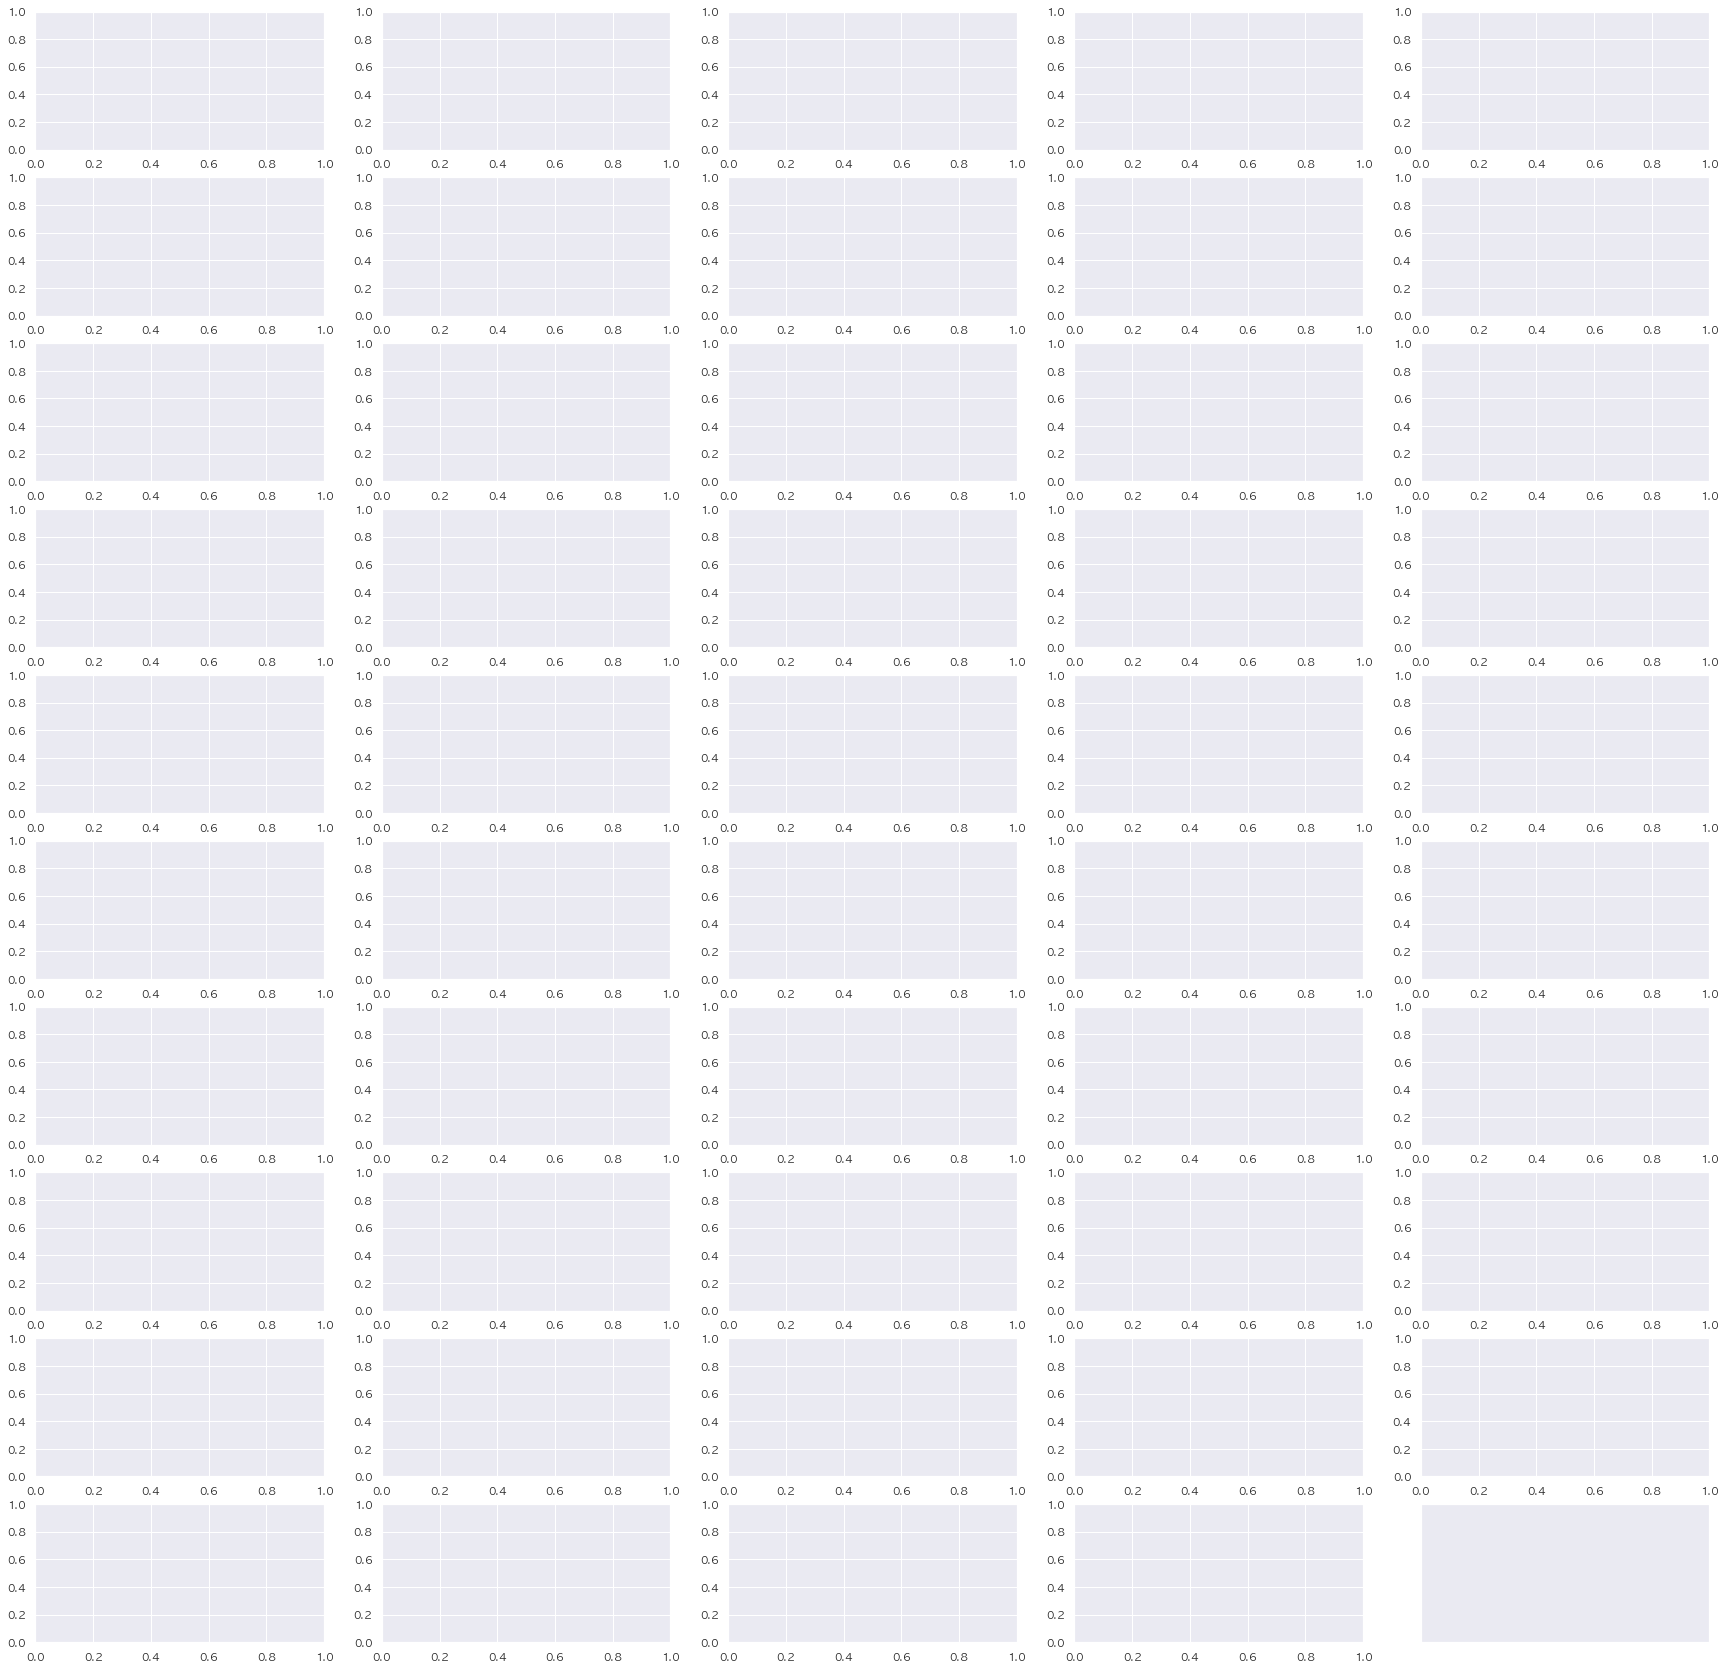

In [324]:
predicts_list = np.array([])
original_list = np.array([])
for _ in range(0, round(len(test_df) / 24), 50):
    test_df = cluster_test_df[_ * 24:(_ + 50) * 24]
    
    feature_length = 2
    predict_data_length = 3
    fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    cnt = 0

    for split in range(0, round(len(test_df)), 24):
        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

        date = test_df[split:(split + 24)].index[0]
        season = get_season(date.month)
        weekday = date.weekday()
        label = cluster_dist_dict[season][weekday]
        c_pattern = cluster_norm_dict[season].loc[label].values

        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
            inputs = inputs.reshape(-1, predict_data_length, feature_length)
            result = lstm_model(inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)
            
        predicts_list = np.append(predicts_list, predicts)
        original_list = np.append(original_list, original[3:])

#         sns.lineplot(original_x_labels, original, lw=2, ax=axes[
#             math.floor(cnt / 5)
#         ][math.floor(cnt % 5)])
#         sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
#             math.floor(cnt / 5)
#         ][math.floor(cnt % 5)])
#         sns.lineplot(original_x_labels, c_pattern, lw=3, ax=axes[
#             math.floor(cnt / 5)
#         ][math.floor(cnt % 5)])

        cnt += 1
plt.show()

In [317]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

test_df = pd.DataFrame(norm_all_dict['univariate']['test']['energy (kw 15min)'].copy())
test_df

col_test_df = pd.DataFrame()
for idx in range(0, len(test_df), 24):
    date = test_df.iloc[idx:].index[0]
    col_test_df[date] = test_df.iloc[idx: idx+24]['energy (kw 15min)'].values
    
mean_pattern = col_test_df.mean(axis=1)

# calc tss, calc wss (only test data)
tss = 0
wss = 0
cluster_distance = np.array([])
cluster_similarity = np.array([])
for idx in range(0, len(test_df), 24):
    # calc tss
    pattern_df = test_df.iloc[idx: idx+24].copy()
    pattern = pattern_df.values.flatten()
    tss += euc(
        mean_pattern[3:],
        pattern[3:]
    ) ** 2
    
    # calc wss
    date = pattern_df.index[0]
    season = get_season(date.month)
    weekday = date.weekday()
    label = cluster_dist_dict[season][weekday]
    
    c_pattern = cluster_norm_dict[season].loc[label].values
    wss += euc(
        c_pattern[3:],
        pattern[3:]
    ) ** 2
    
    distance = euc(
        c_pattern[3:],
        pattern[3:]
    )
    similarity = cos_sim(
        c_pattern[3:],
        pattern[3:]
    )
    
    cluster_distance = np.append(cluster_distance, [distance])
    cluster_similarity = np.append(cluster_similarity, [similarity])
    
mean_dis = cluster_distance.mean()
mean_sim = cluster_similarity.mean()
cluster_ecv = (1 - (wss / tss)) * 100
print("tss is {}, wss is {}, mean dis is {}, mean sim is {}, ecv is {}%".format(tss, wss, mean_dis, mean_sim, cluster_ecv))

evaluate_df = pd.DataFrame(columns=['ecv', 'mean dis', 'mean sim'])
evaluate_df.loc['cluster pattern'] = [
    cluster_ecv,
    mean_dis,
    mean_sim
]
evaluate_df

tss is 1456.9100393977487, wss is 3568.1966976425047, mean dis is 3.9987579243325984, mean sim is 0.4528471517959315, ecv is -144.91537577141762%


,ecv,mean dis,mean sim
cluster pattern,-144.915376,3.998758,0.452847


In [325]:
len(predicts_list)

1050

In [326]:
len(original_list)

1050

In [329]:
predicts_list = predicts_list.reshape(-1,21)
original_list = original_list.reshape(-1,21)

In [330]:
wss = 0
distances = list()
similarities = list()

for idx, p_pattern in enumerate(predicts_list):
    o_pattern = original_list[idx]
    
    wss += euc(
        p_pattern,
        o_pattern
    ) ** 2
    
    distances.append(
        euc(
            p_pattern,
            o_pattern
        )
    )
    
    similarities.append(
        cos_sim(
            p_pattern,
            o_pattern
        )
    )

In [331]:
evaluate_df.loc['with cluster'] = [
        (1 - (wss / tss)) * 100,
        np.array(distances).mean(),
        np.array(similarities).mean()
]


In [332]:
evaluate_df

,ecv,mean dis,mean sim
cluster pattern,-144.915376,3.998758,0.452847
with cluster,97.095266,0.905008,0.949703
